# Mean-reversion
## Part1
1.Mean-reversion with threshold\
2.RSI\
3.Bollinger Bands\
4.Combine mean-reversion\
5.MACD\
6.Combine RSI and MACD (I am still trying to make it)
## Part2
1.Sharpe ratio\
2.Maximum Drawdown & Duration, MDD \
3.Compound annual growth rate, CAGR\
4.How much is left on your account\
5.DataFrame

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import datetime # as dt
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(precision = 3)
plt.style.use("ggplot") # Grammar of Graphics Theme
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14
%matplotlib inline

In [2]:
import pandas_datareader.data as web 
from pandas_datareader import data as pdr
import yfinance as yf
(
    yf
    .pdr_override()
)

In [3]:
spy =(pdr
    .get_data_yahoo("SPY",
                    start = dt.datetime(2004, 11, 1),
                    end = dt.datetime(2023, 11, 1)
                   ))

[*********************100%%**********************]  1 of 1 completed


In [4]:
spy = spy.reset_index()

In [5]:
spy['date'] =spy['Date'].copy()
spy['Date'] = pd.to_datetime(spy['Date'], format='%Y-%m-%d')  # 将字符串转换为日期格式
spy['Date'] = spy['Date'].dt.strftime('%Y%m%d') 
spy = spy.set_index("date")

In [6]:
spy['Date'] = pd.to_numeric(spy['Date'], errors='coerce')
spy[(spy["Date"]< 20200101) & (spy["Date"]> 20140101)]

,Date,Open,High,Low,Close,Adj Close,Volume
date,,,,,,,
2014-01-02,20140102,183.979996,184.070007,182.479996,182.919998,153.288116,119636900
2014-01-03,20140103,183.229996,183.600006,182.630005,182.889999,153.262970,81390600
2014-01-06,20140106,183.490005,183.559998,182.080002,182.360001,152.818848,108028200
2014-01-07,20140107,183.089996,183.789993,182.949997,183.479996,153.757446,86144200
2014-01-08,20140108,183.449997,183.830002,182.889999,183.520004,153.790924,96582300
...,...,...,...,...,...,...,...
2019-12-24,20191224,321.470001,321.519989,320.899994,321.230011,302.863434,20270000
2019-12-26,20191226,321.649994,322.950012,321.640015,322.940002,304.475586,30911200
2019-12-27,20191227,323.739990,323.799988,322.279999,322.859985,304.400177,42528800


<Axes: xlabel='date'>

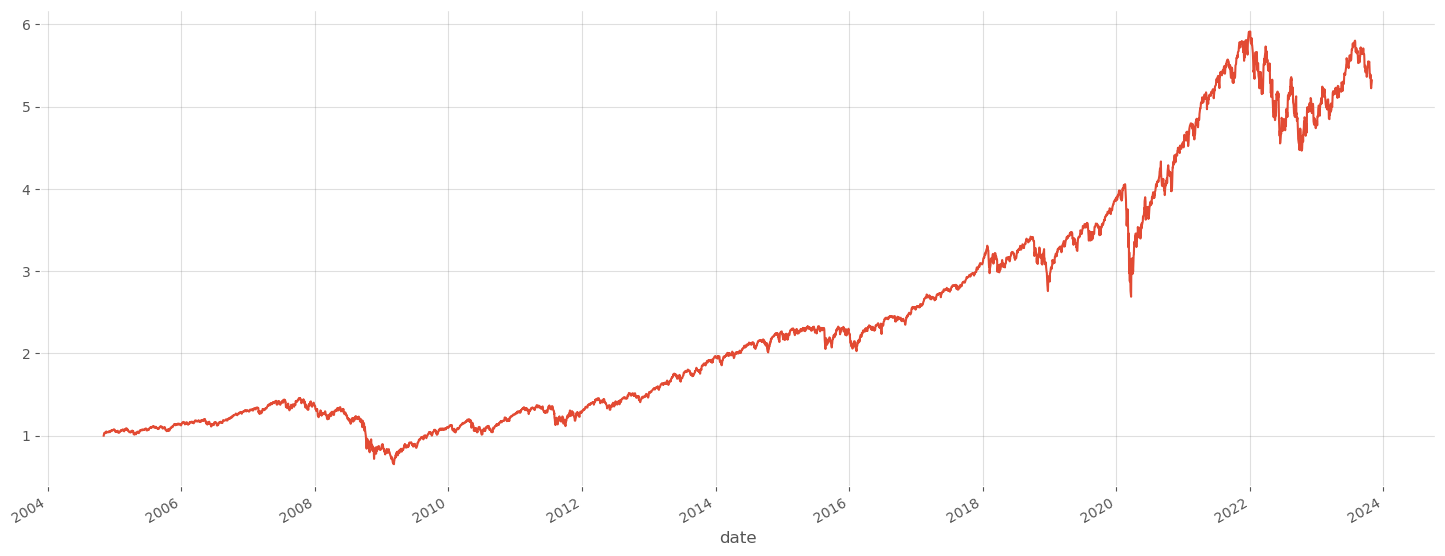

In [7]:
spy["log_return"] =np.log(spy["Adj Close"]/spy["Adj Close"].shift(1))
spy["log_return"].cumsum().apply(np.exp).plot(figsize = [18, 7])

# Part1
## 1.Mean-reversion with threshold

In [8]:
def mean_reversion1(windows,threshold):
    spy1 =spy.copy()
    spy1["SMA"] = spy1["Adj Close"].rolling(window = windows).mean()
    spy1["distance"] = spy1["Adj Close"] - spy1["SMA"]   
    spy1["trading_positions"] = np.where(spy1["distance"] > threshold, 1, np.nan)
    spy1["trading_positions"] = np.where(spy1["distance"] < -threshold, -1, spy1["trading_positions"])
    spy1["trading_positions"] = np.where(spy1["distance"] * spy1["distance"].shift(1) < 0, 0, spy1["trading_positions"])
    spy1["trading_positions"].ffill(inplace=True)
    spy1["trading_positions"] = spy1["trading_positions"].fillna(0)
    spy1["daily_return"] = spy1["Adj Close"].pct_change()
    
    spy1= spy1[(spy1["Date"]< 20190501) & (spy1["Date"]> 20120101)]
    spy1["str_return"] = spy1["trading_positions"]*spy1["daily_return"]
    spy1["str return"] = (1+spy1["str_return"]).cumprod()
    spy1["cul_return"] = spy1["log_return"].cumsum().apply(np.exp)
    spy1[["str return","cul_return"]].plot(figsize = [18, 7])
    return spy1

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,SMA,distance,trading_positions,daily_return,str_return,str return,cul_return
date,,,,,,,,,,,,,,,
2012-01-03,20120103,127.760002,128.380005,127.430000,127.500000,102.458961,193697900,0.015811,99.079449,3.379512,0.0,0.015936,0.000000,1.000000,1.015936
2012-01-04,20120104,127.199997,127.809998,126.709999,127.699997,102.619698,127186500,0.001568,99.165385,3.454313,0.0,0.001569,0.000000,1.000000,1.017530
2012-01-05,20120105,127.010002,128.229996,126.430000,128.039993,102.892914,173895000,0.002659,99.214857,3.678057,0.0,0.002662,0.000000,1.000000,1.020239
2012-01-06,20120106,128.199997,128.220001,127.290001,127.709999,102.627716,148050000,-0.002581,99.272654,3.355062,0.0,-0.002577,-0.000000,1.000000,1.017609
2012-01-09,20120109,128.000000,128.179993,127.410004,128.020004,102.876846,99530200,0.002425,99.321554,3.555293,0.0,0.002428,0.000000,1.000000,1.020080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-24,20190424,292.790009,293.160004,292.070007,292.230011,271.592346,50392900,-0.002222,263.145859,8.446487,1.0,-0.002219,-0.002219,2.680811,2.692985
2019-04-25,20190425,292.119995,292.779999,290.730011,292.049988,271.424896,57770900,-0.000617,263.450246,7.974650,1.0,-0.000617,-0.000617,2.679158,2.691325
2019-04-26,20190426,292.100006,293.489990,291.239990,293.410004,272.688904,50916400,0.004646,263.789135,8.899769,1.0,0.004657,0.004657,2.691635,2.703858


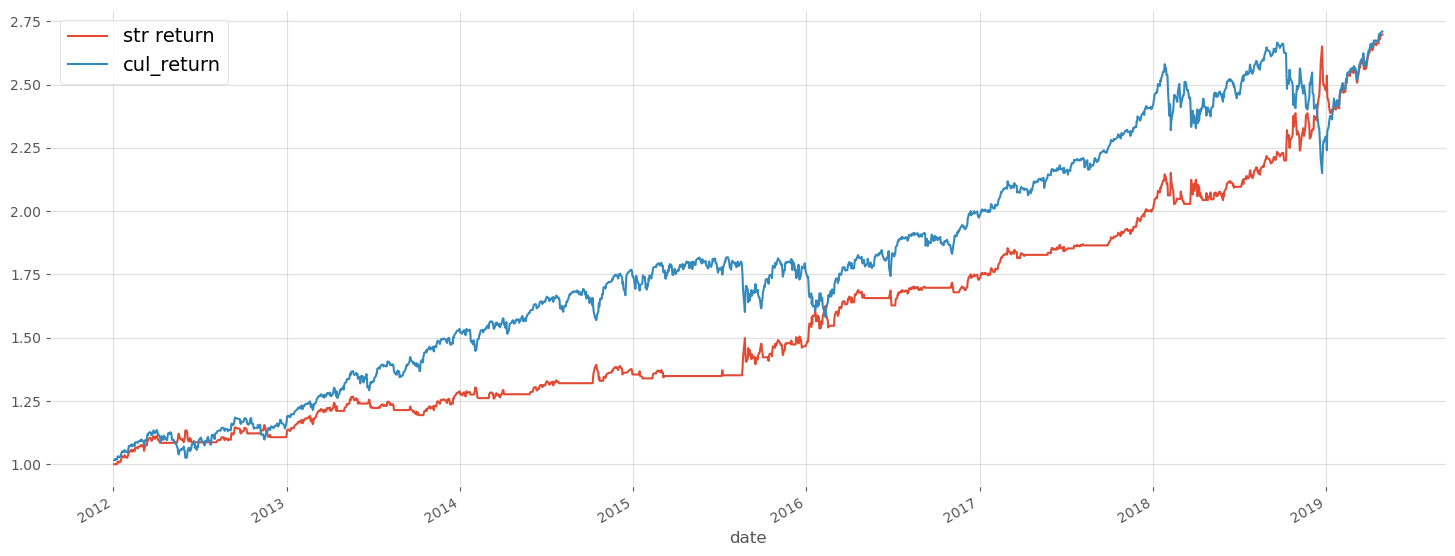

In [9]:
mean_reversion1(42,4)

In [10]:
def strength(stock):
    return stock["str return"][-1] - stock["cul_return"][-1]

In [11]:
# list_mr = []
# for i in range(15,63):
#     for j in range(1,6):
#         list_mr.append(strength(mean_reversion1(i,j)))

In [12]:
# pd.DataFrame(list_mr).max()

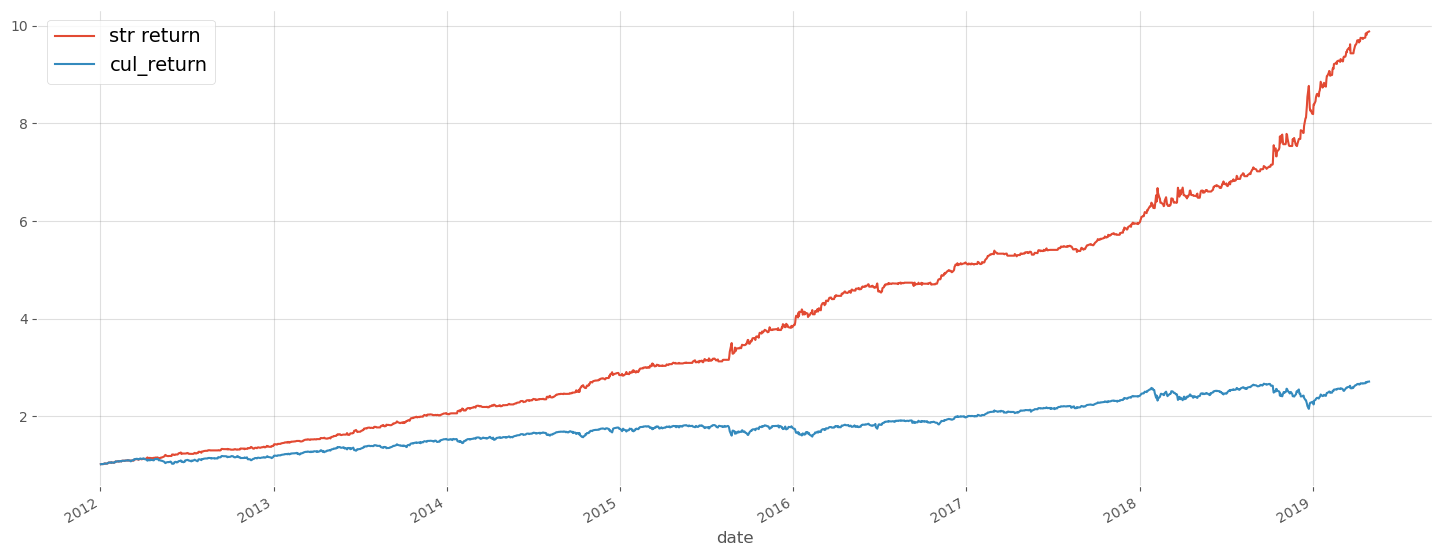

In [13]:
df_threshold = mean_reversion1(15,1)

## 2.RSI

In [14]:
def mean_rsi(period):
    spy2 = spy.copy()
    spy2["change"] = spy2["Adj Close"].diff()

    spy2["gain"] = spy2["change"].apply(lambda x: x if x > 0 else 0)
    spy2["loss"] = spy2["change"].apply(lambda x: -x if x < 0 else 0)

    spy2["avg_gain"] = spy2["gain"].rolling(period).mean()
    spy2["avg_loss"] = spy2["loss"].rolling(period).mean()
    for i in range(period,len(spy2)):
        spy2.iloc[i, spy2.columns.get_loc("avg_gain")] = (spy2.iloc[i-1]["avg_gain"]*(period-1)+spy2.iloc[i]["gain"])/period
        spy2.iloc[i, spy2.columns.get_loc("avg_loss")] = (spy2.iloc[i-1]["avg_loss"]*(period-1)+spy2.iloc[i]["loss"])/period

    spy2["RS"] = spy2["avg_gain"]/spy2["avg_loss"]
    spy2["RSI"] = 100 - 100/(1+spy2["RS"])
    spy2["position_RSI"] = np.where(spy2["RSI"]<50, -1, 1)
    spy2["position_RSI"].ffill(inplace=True)
    spy2["position_RSI"] = spy2["position_RSI"].fillna(0)

    spy2["daily_return"] = spy2["Adj Close"].pct_change()
    spy2["str_return"] = spy2["position_RSI"]*spy2["daily_return"]
    spy2["str return"] = (1+spy2["str_return"]).cumprod()
    spy2["cul_return"] = spy2["log_return"].cumsum().apply(np.exp)
    spy2[["str return","cul_return"]].plot(figsize = [18, 7])
    return spy2

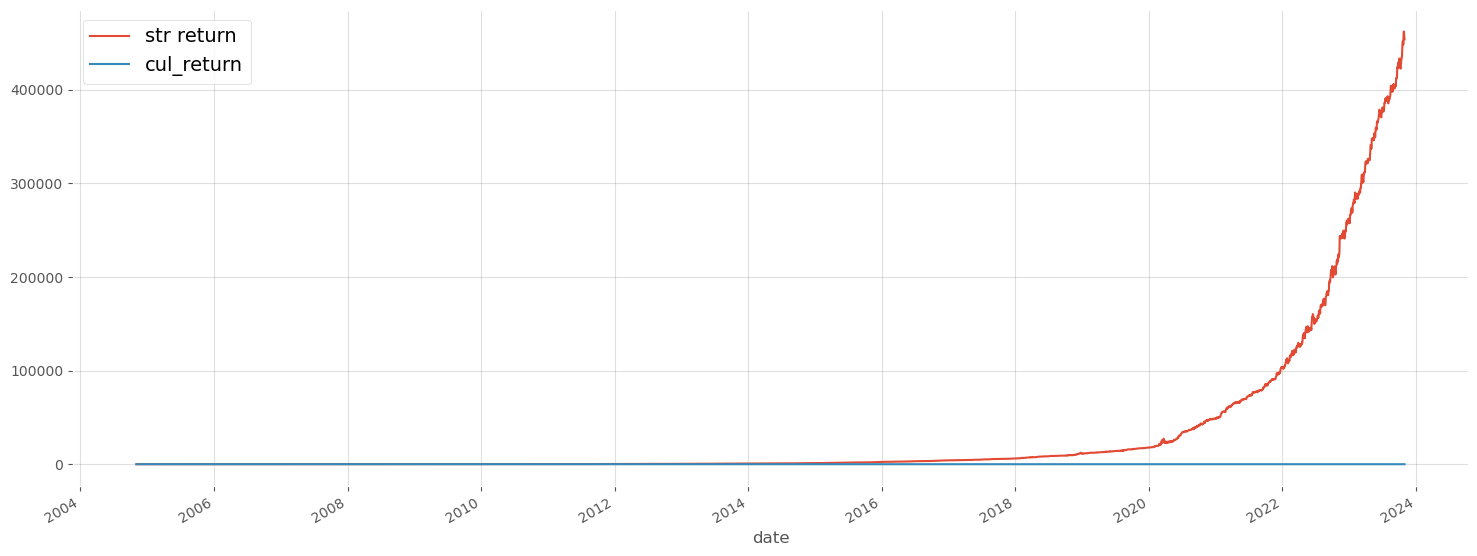

In [15]:
df_rsi = mean_rsi(14)

## 3.Bollinger Bands

In [43]:
def mean_reversion2(windows,path):
    spy3 = spy.copy()
    spy3["SMA_window"] = spy3["Adj Close"].rolling(windows).mean()
    spy3["Distance3"] = spy3["Adj Close"] - spy3["SMA_window"]           
    spy3["Upper_threshold"] = path*spy3["Adj Close"].rolling(windows).std()+spy3["Adj Close"]
    spy3["Lower_threshold"] = -path*spy3["Adj Close"].rolling(windows).std()+spy3["Adj Close"]

    spy3["Trading_position3"] = np.where(spy3["SMA_window"] > spy3["Upper_threshold"], -1, np.nan)
    spy3["Trading_position3"] = np.where(spy3["SMA_window"] < spy3["Lower_threshold"], 1, spy3["Trading_position3"])
    spy3["Trading_position3"] = np.where(spy3["Distance3"]*spy3["Distance3"].shift(1) < 0, 0, spy3["Trading_position3"])
    spy3["Trading_position3"].ffill(inplace=True)
    spy3["Trading_position3"] = spy3["Trading_position3"].fillna(0)

    spy3["strategy_returns3"] = spy3["Trading_position3"].shift(1)*spy3["log_return"] 
    spy3["daily_return"] = spy3["Adj Close"].pct_change()
    spy3["str_return"] = spy3["Trading_position3"]*spy3["daily_return"]
    spy3["str return"] = (1+spy3["str_return"]).cumprod()
    spy3["cul_return"] = spy3["log_return"].cumsum().apply(np.exp)
    spy3[["str return","cul_return"]].plot(figsize = [18, 7])
    return spy3

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,SMA_window,Distance3,Upper_threshold,Lower_threshold,Trading_position3,strategy_returns3,daily_return,str_return,cul_return
date,,,,,,,,,,,,,,,,,
2004-11-01,20041101,113.559998,113.839996,113.199997,113.510002,78.617950,36720900,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2004-11-02,20041102,113.669998,114.570000,113.220001,113.550003,78.645645,56210000,0.000352,NaN,NaN,NaN,NaN,0.0,0.000000,0.000352,1.000000,1.000352
2004-11-03,20041103,115.029999,115.360001,114.239998,114.980003,79.636055,76960200,0.012515,NaN,NaN,NaN,NaN,0.0,0.000000,0.012593,1.000000,1.012950
2004-11-04,20041104,114.779999,116.669998,114.680000,116.550003,80.723465,55350300,0.013562,NaN,NaN,NaN,NaN,0.0,0.000000,0.013655,1.000000,1.026782
2004-11-05,20041105,117.050003,117.639999,116.489998,117.279999,81.229073,63287200,0.006244,NaN,NaN,NaN,NaN,0.0,0.000000,0.006263,1.000000,1.033213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,20231025,421.890015,421.920013,417.019989,417.549988,417.549988,94223200,-0.014456,435.212083,-17.662095,436.525910,398.574066,-1.0,0.014456,-0.014352,6.386575,5.311128
2023-10-26,20231026,416.450012,417.329987,411.600006,412.549988,412.549988,115156800,-0.012047,434.529851,-21.979863,432.669144,392.430831,-1.0,0.012047,-0.011975,6.463052,5.247529
2023-10-27,20231027,414.190002,414.600006,409.209991,410.679993,410.679993,107367700,-0.004543,433.651249,-22.971257,431.667922,389.692063,-1.0,0.004543,-0.004533,6.492347,5.223743


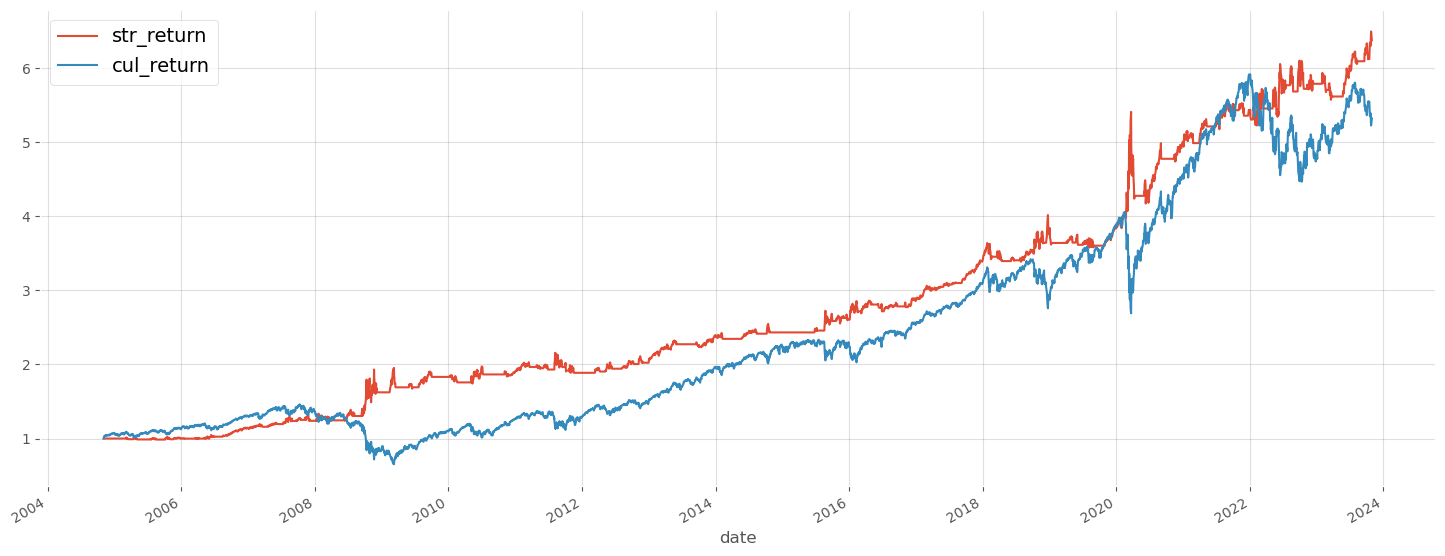

In [17]:
mean_reversion2(42,2)

In [18]:
# list_bb = []
# for i in range(15,63):
#     for j in range(1,6):
#         list_bb.append( mean_reversion2(i,j)))

In [19]:
# pd.DataFrame(list_bb).max()

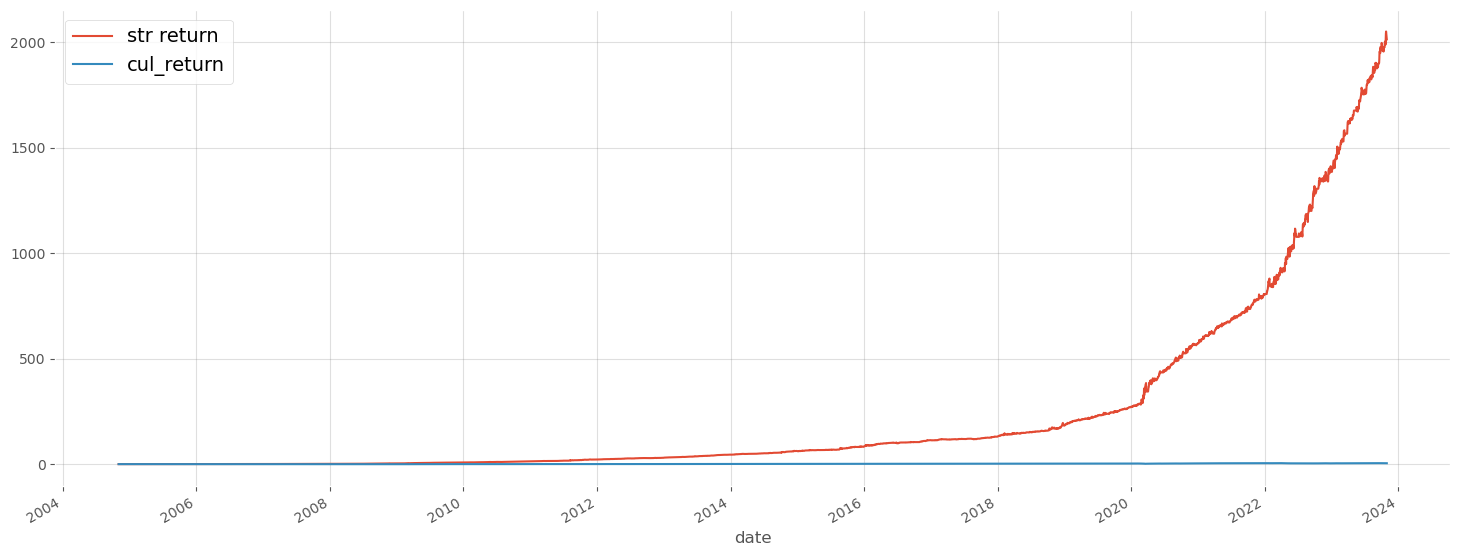

In [44]:
df_bb = mean_reversion2(15,1)

## 4.Combine mean-reversion

In [21]:
def mean_reversion_threshold_std(windows,threshold,path,period):
    spy1 =spy.copy()
    spy1["SMA"] = spy1["Adj Close"].rolling(window = windows).mean()
    spy1["distance"] = spy1["Adj Close"] - spy1["SMA"]   
    spy1["trading_positions"] = np.where(spy1["distance"] > threshold, 1, np.nan)
    spy1["trading_positions"] = np.where(spy1["distance"] < -threshold, -1, spy1["trading_positions"])
    spy1["trading_positions"] = np.where(spy1["distance"] * spy1["distance"].shift(1) < 0, 0, spy1["trading_positions"])
    spy1["trading_positions"].ffill(inplace=True)
    spy1["trading_positions"] = spy1["trading_positions"].fillna(0)
    spy1["daily_return"] = spy1["Adj Close"].pct_change()
    
    # Bollinger Bands
    spy1["SMA_window"] = spy1["Adj Close"].rolling(window=windows).mean()
    spy1["Distance3"] = spy1["Adj Close"] - spy1["SMA_window"]
    spy1["Upper_threshold"] = path*spy1["Adj Close"].rolling(window=windows).std()+spy1["Adj Close"]
    spy1["Lower_threshold"] = -path*spy1["Adj Close"].rolling(window=windows).std()+spy1["Adj Close"]
    spy1["Trading_position3"] = np.where(spy1["SMA_window"] > spy1["Upper_threshold"], -1, np.nan)
    spy1["Trading_position3"] = np.where(spy1["SMA_window"] < spy1["Lower_threshold"], 1, spy1["Trading_position3"])
    spy1["Trading_position3"] = np.where(spy1["Distance3"]*spy1["Distance3"].shift(1) < 0, 0, spy1["Trading_position3"])
    spy1["Trading_position3"].ffill(inplace=True)
    spy1["Trading_position3"] = spy1["Trading_position3"].fillna(0)
    
    # RSI
    spy1["change"] = spy1["Adj Close"].diff()
    spy1["gain"] = spy1["change"].apply(lambda x: x if x > 0 else 0)
    spy1["loss"] = spy1["change"].apply(lambda x: -x if x < 0 else 0)
    spy1["avg_gain"] = spy1["gain"].rolling(period).mean()
    spy1["avg_loss"] = spy1["loss"].rolling(period).mean()
    for i in range(period,len(spy1)):
        spy1.iloc[i, spy1.columns.get_loc("avg_gain")] = (spy1.iloc[i-1]["avg_gain"]*(period-1)+spy1.iloc[i]["gain"])/period
        spy1.iloc[i, spy1.columns.get_loc("avg_loss")] = (spy1.iloc[i-1]["avg_loss"]*(period-1)+spy1.iloc[i]["loss"])/period
    spy1["RS"] = spy1["avg_gain"]/spy1["avg_loss"]
    spy1["RSI"] = 100 - 100/(1+spy1["RS"])
    spy1["position_RSI"] = np.where(spy1["RSI"]<50, -1, 1)
    spy1["str_return"] = spy1["position_RSI"].shift(1)*spy1["log_return"]
    spy1["str_return"].fillna(0, inplace=True)
    
    spy1['combine'] = spy1["position_RSI"] + spy1["trading_positions"] + spy1["Trading_position3"]
    spy1["Positionspin"] = 0
    spy1["Positionspin"] = np.where(spy1['combine']>0,1,spy1["Positionspin"])
    spy1["Positionspin"] = np.where(spy1['combine']<0,-1,spy1["Positionspin"])
    
#     spy1= spy1[(spy1["Date"]< 20190501) & (spy1["Date"]> 20120101)]
    
    spy1["str_return"] = spy1["Positionspin"]*spy1["daily_return"]
    spy1["str return"] = (1+spy1["str_return"]).cumprod()
    spy1["cul_return"] = spy1["log_return"].cumsum().apply(np.exp)
    spy1[["str return","cul_return"]].plot(figsize = [18, 7])
    return spy1

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,SMA,distance,...,avg_gain,avg_loss,RS,RSI,position_RSI,str_return,combine,Positionspin,str return,cul_return
date,,,,,,,,,,,,,,,,,,,,,
2004-11-01,20041101,113.559998,113.839996,113.199997,113.510002,78.617950,36720900,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,1.0,1,NaN,NaN
2004-11-02,20041102,113.669998,114.570000,113.220001,113.550003,78.645645,56210000,0.000352,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0.000352,1.0,1,1.000352,1.000352
2004-11-03,20041103,115.029999,115.360001,114.239998,114.980003,79.636055,76960200,0.012515,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0.012593,1.0,1,1.012950,1.012950
2004-11-04,20041104,114.779999,116.669998,114.680000,116.550003,80.723465,55350300,0.013562,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0.013655,1.0,1,1.026782,1.026782
2004-11-05,20041105,117.050003,117.639999,116.489998,117.279999,81.229073,63287200,0.006244,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0.006263,1.0,1,1.033213,1.033213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,20231025,421.890015,421.920013,417.019989,417.549988,417.549988,94223200,-0.014456,435.212083,-17.662095,...,1.057388,2.021655,0.523031,34.341441,-1,0.014352,-3.0,-1,4179.186123,5.311128
2023-10-26,20231026,416.450012,417.329987,411.600006,412.549988,412.549988,115156800,-0.012047,434.529851,-21.979863,...,0.981860,2.234394,0.439430,30.528061,-1,0.011975,-3.0,-1,4229.230264,5.247529
2023-10-27,20231027,414.190002,414.600006,409.209991,410.679993,410.679993,107367700,-0.004543,433.651249,-22.971257,...,0.911727,2.208366,0.412852,29.221156,-1,0.004533,-3.0,-1,4248.400402,5.223743


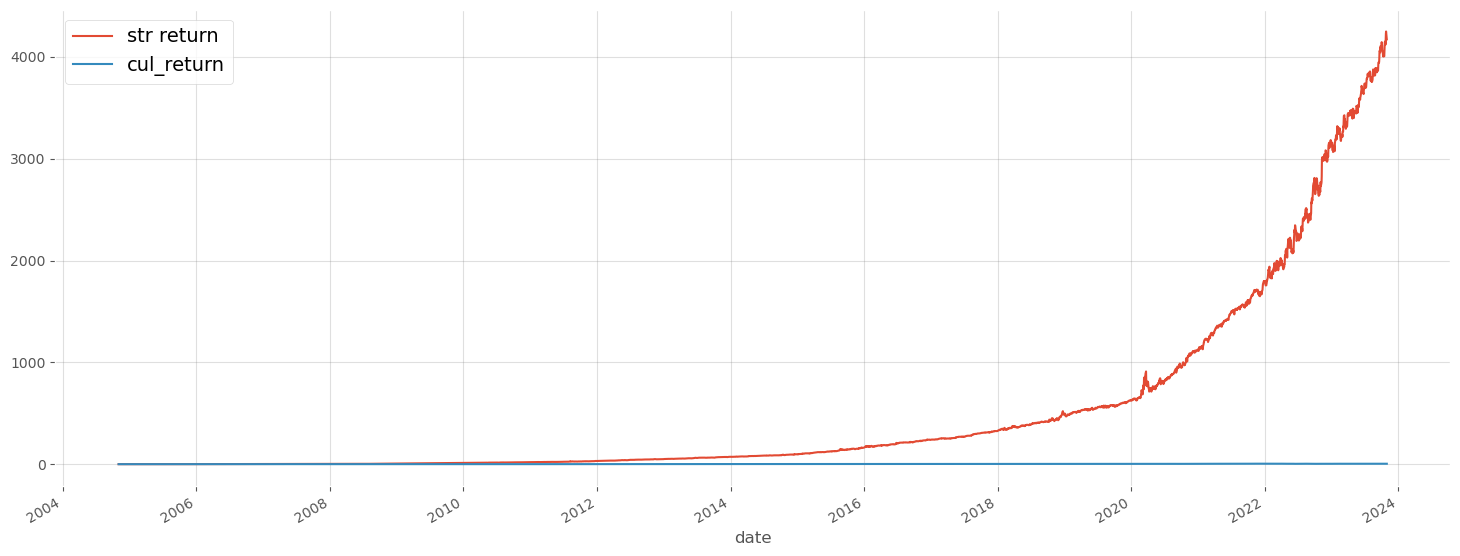

In [22]:
mean_reversion_threshold_std(42,1,1,14)

In [23]:
# list_com =[]
# for i in range (15,43):
#     for j in range(1,6):
#         for n in range(10,21):
#             list_com.append([mean_reversion_threshold_std(i,j,1,n),i,j,n])

In [24]:
# pd.DataFrame(list_com).max()

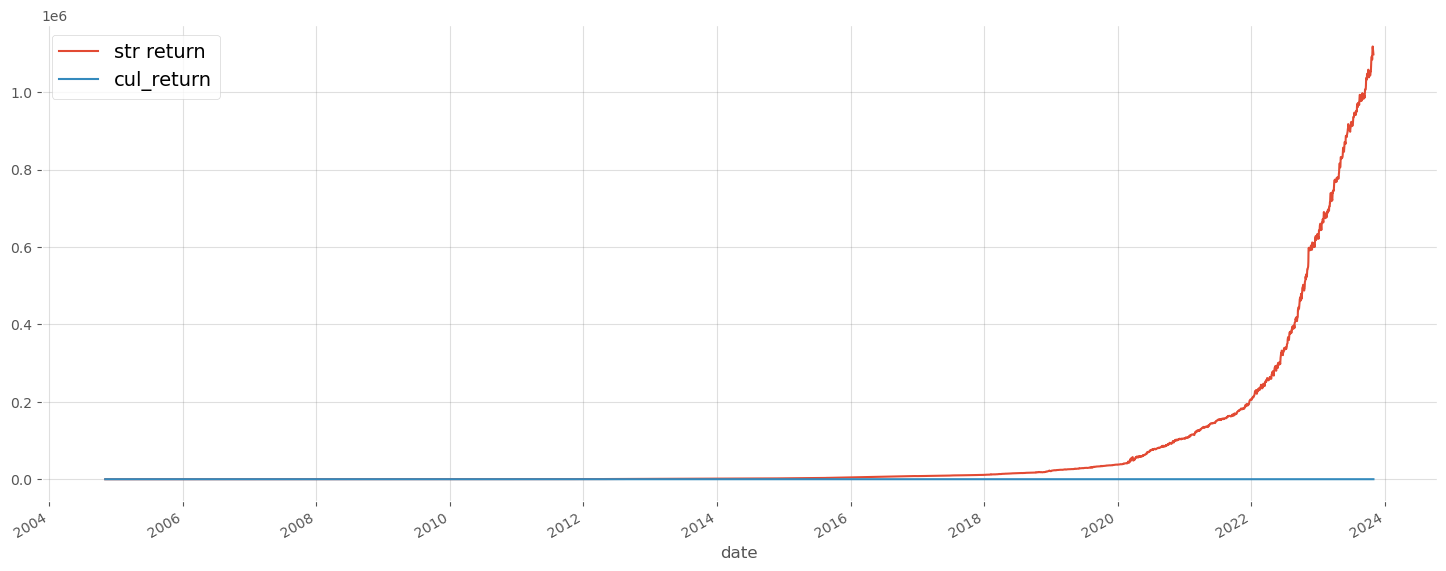

In [25]:
df_cm = mean_reversion_threshold_std(15,1,1,10)

## 5. MACD

In [26]:
def MACD(short,long,signal):
    spy5 = spy.copy()
    spy5["mean_short"] = spy5[["Adj Close"]].rolling(short).mean()
    spy5["mean_long"] = spy5[["Adj Close"]].rolling(long).mean()
    spy5["MACD"]=spy5["mean_short"]-spy5["mean_long"]
    spy5["MACD_signal"] = spy5[["MACD"]].rolling(signal).mean()
    spy5["Trading_Positions"] = np.where(spy5["MACD"] > spy5["MACD_signal"],1, -1)
    spy5["Trading_Positions"].ffill(inplace=True)
    spy5["Trading_Positions"].fillna(0, inplace=True)

    spy5["daily_return"] = spy5["Adj Close"].pct_change()
    spy5["str_return"] = spy5["Trading_Positions"]*spy5["daily_return"]
    spy5["str_return"].fillna(0, inplace=True)
    spy5["str return"] = (1+spy5["str_return"]).cumprod()
    spy5["cul_return"] = spy5["log_return"].cumsum().apply(np.exp)
    spy5[["str return","cul_return"]].plot(figsize = [18, 7])
    return spy5

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,mean_short,mean_long,MACD,MACD_signal,Trading_Positions,daily_return,str_return,str return,cul_return
date,,,,,,,,,,,,,,,,,
2004-11-01,20041101,113.559998,113.839996,113.199997,113.510002,78.617950,36720900,NaN,NaN,NaN,NaN,NaN,-1,NaN,0.000000,1.000000,NaN
2004-11-02,20041102,113.669998,114.570000,113.220001,113.550003,78.645645,56210000,0.000352,NaN,NaN,NaN,NaN,-1,0.000352,-0.000352,0.999648,1.000352
2004-11-03,20041103,115.029999,115.360001,114.239998,114.980003,79.636055,76960200,0.012515,NaN,NaN,NaN,NaN,-1,0.012593,-0.012593,0.987059,1.012950
2004-11-04,20041104,114.779999,116.669998,114.680000,116.550003,80.723465,55350300,0.013562,NaN,NaN,NaN,NaN,-1,0.013655,-0.013655,0.973581,1.026782
2004-11-05,20041105,117.050003,117.639999,116.489998,117.279999,81.229073,63287200,0.006244,NaN,NaN,NaN,NaN,-1,0.006263,-0.006263,0.967483,1.033213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,20231025,421.890015,421.920013,417.019989,417.549988,417.549988,94223200,-0.014456,428.962499,428.771156,0.191343,-1.696827,1,-0.014352,-0.014352,7.715297,5.311128
2023-10-26,20231026,416.450012,417.329987,411.600006,412.549988,412.549988,115156800,-0.012047,427.129997,427.767693,-0.637696,-1.200477,1,-0.011975,-0.011975,7.622909,5.247529
2023-10-27,20231027,414.190002,414.600006,409.209991,410.679993,410.679993,107367700,-0.004543,424.993329,426.971154,-1.977824,-0.956481,-1,-0.004533,0.004533,7.657462,5.223743


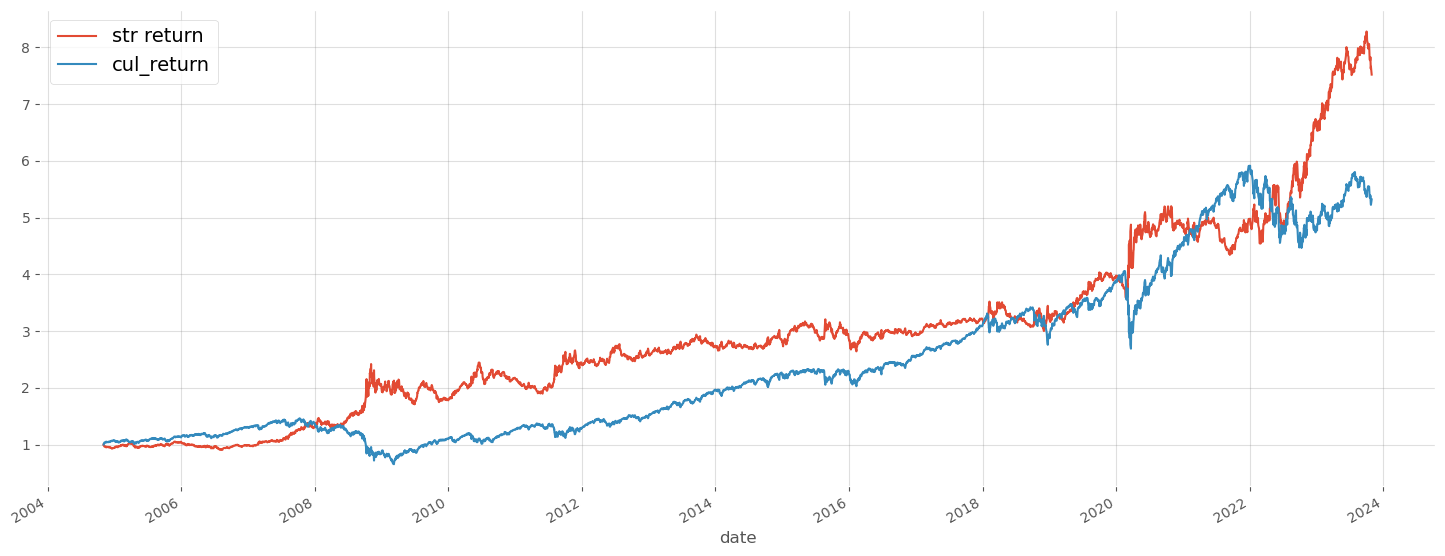

In [27]:
MACD(12,26,9)

In [28]:
# list_macd =[]
# for i in range (10,16):
#     for j in range(21,31):
#         for n in range(5,10):
#             list_macd.append([strength(MACD(i,j,n)),i,j,n])

In [29]:
# df_list_macd =  pd.DataFrame(list_macd)
# df_list_macd[df_list_macd[0] == df_list_macd [0].max()] 

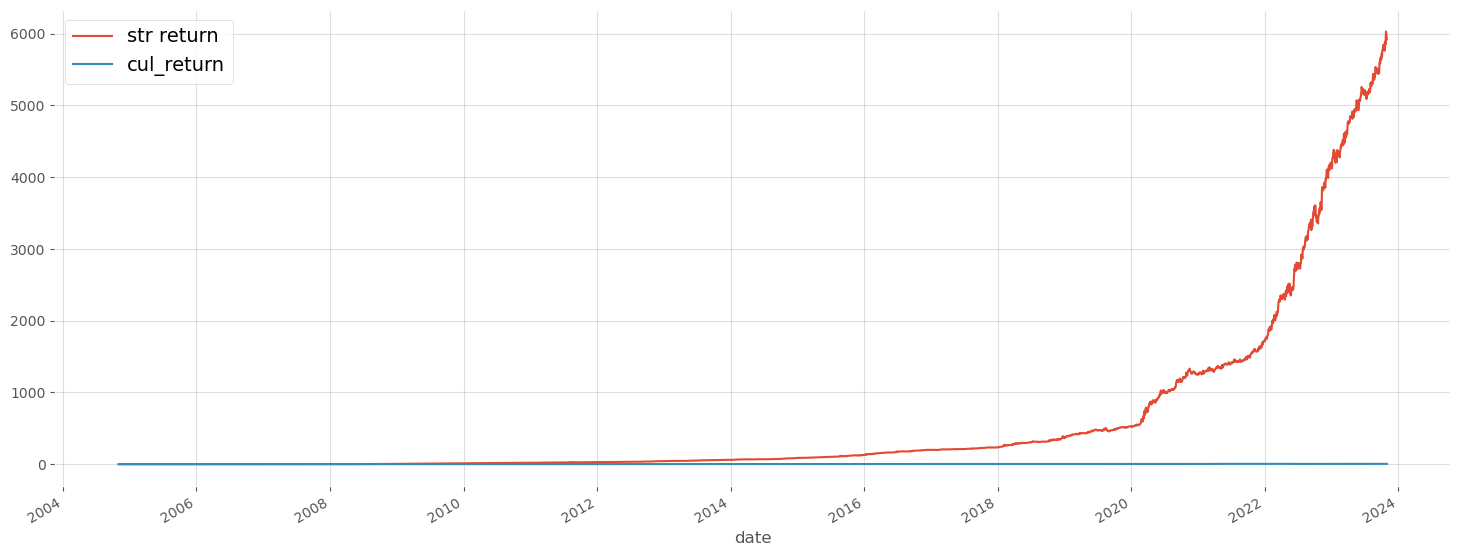

In [66]:
df_macd = MACD(6,63,3)

## 6.Combine RSI and MACD

In [31]:
# #short and long EWM
# short_EWM = 12
# long_EWM = 26
# signal = 9
# period = 14
# def RSI_MACD(short_EWM,long_EWM,signal,period):
#     spy5 = spy.copy()
#     spy5["short_EWM"] = spy5["Adj Close"].ewm(span=short_EWM).mean()
#     spy5["long_EWM"] = spy5["Adj Close"].ewm(span=long_EWM).mean()

#     spy5["MACD"] = spy5["short_EWM"] - spy5["long_EWM"]
#     spy5["MACD_signal"] = spy5["MACD"].ewm(span = signal).mean()
#     spy5["position_MACD"] = np.where(spy5["MACD"] > spy5["MACD_signal"], 1, -1)

#     spy5["change"] = spy5["Adj Close"].diff()
#     spy5["gain"] = spy5["change"].apply(lambda x: x if x > 0 else 0)
#     spy5["loss"] = spy5["change"].apply(lambda x: -x if x < 0 else 0)

#     spy5["avg_gain"] = spy5["gain"].rolling(period).mean()
#     spy5["avg_loss"] = spy5["loss"].rolling(period).mean()
#     for i in range(period,len(spy5)):
#         spy5.iloc[i, spy5.columns.get_loc("avg_gain")] = (spy5.iloc[i-1]["avg_gain"]*(period-1)+spy5.iloc[i]["gain"])/period
#         spy5.iloc[i, spy5.columns.get_loc("avg_loss")] = (spy5.iloc[i-1]["avg_loss"]*(period-1)+spy5.iloc[i]["loss"])/period    
#     spy5["RS"] = spy5["avg_gain"]/spy5["avg_loss"]
#     spy5["RSI"] = 100 - 100/(1+spy5["RS"])

#     spy5["position_RSI"] = np.where(spy5["RSI"]<50, 1, -1)
#     spy5["position"] = np.where((spy5["position_MACD"]==-1)&(spy5["position_RSI"]==-1), -1, np.nan)
#     spy5["position"] = np.where((spy5["position_MACD"]==1)&(spy5["position_RSI"]==1), 1, spy5["position"])
#     spy5["position"] = spy5["position"].shift(1)
#     spy5["position"].ffill(inplace=True)
#     spy5["position"].fillna(0, inplace=True)


#     spy5["daily_return"] = spy5["Adj Close"].pct_change()
#     spy5["str_return"] = spy5["position"]*spy5["daily_return"]
#     spy5["str_return"].fillna(0, inplace=True)
#     spy5["str return"] = (1+spy5["str_return"]).cumprod()
#     spy5["cul_return"] = spy5["log_return"].cumsum().apply(np.exp)
#     spy5[["str return","cul_return"]].plot(figsize = [18, 7])
#     return spy5

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,short_EWM,long_EWM,...,avg_gain,avg_loss,RS,RSI,position_RSI,position,daily_return,str_return,str return,cul_return
date,,,,,,,,,,,,,,,,,,,,,
2004-11-01,20041101,113.559998,113.839996,113.199997,113.510002,78.617950,36720900,NaN,78.617950,78.617950,...,NaN,NaN,NaN,NaN,-1,0.0,NaN,0.000000,1.000000,NaN
2004-11-02,20041102,113.669998,114.570000,113.220001,113.550003,78.645645,56210000,0.000352,78.632952,78.632259,...,NaN,NaN,NaN,NaN,-1,-1.0,0.000352,-0.000352,0.999648,1.000352
2004-11-03,20041103,115.029999,115.360001,114.239998,114.980003,79.636055,76960200,0.012515,79.024463,78.989404,...,NaN,NaN,NaN,NaN,-1,-1.0,0.012593,-0.012593,0.987059,1.012950
2004-11-04,20041104,114.779999,116.669998,114.680000,116.550003,80.723465,55350300,0.013562,79.560772,79.467201,...,NaN,NaN,NaN,NaN,-1,-1.0,0.013655,-0.013655,0.973581,1.026782
2004-11-05,20041105,117.050003,117.639999,116.489998,117.279999,81.229073,63287200,0.006244,80.014043,79.868069,...,NaN,NaN,NaN,NaN,-1,-1.0,0.006263,-0.006263,0.967483,1.033213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,20231025,421.890015,421.920013,417.019989,417.549988,417.549988,94223200,-0.014456,426.155765,430.681710,...,1.057388,2.021655,0.523031,34.341441,1,1.0,-0.014352,-0.014352,0.312392,5.311128
2023-10-26,20231026,416.450012,417.329987,411.600006,412.549988,412.549988,115156800,-0.012047,424.062568,429.511921,...,0.981860,2.234394,0.439430,30.528061,1,1.0,-0.011975,-0.011975,0.308651,5.247529
2023-10-27,20231027,414.190002,414.600006,409.209991,410.679993,410.679993,107367700,-0.004543,422.003710,428.296958,...,0.911727,2.208366,0.412852,29.221156,1,1.0,-0.004533,-0.004533,0.307252,5.223743


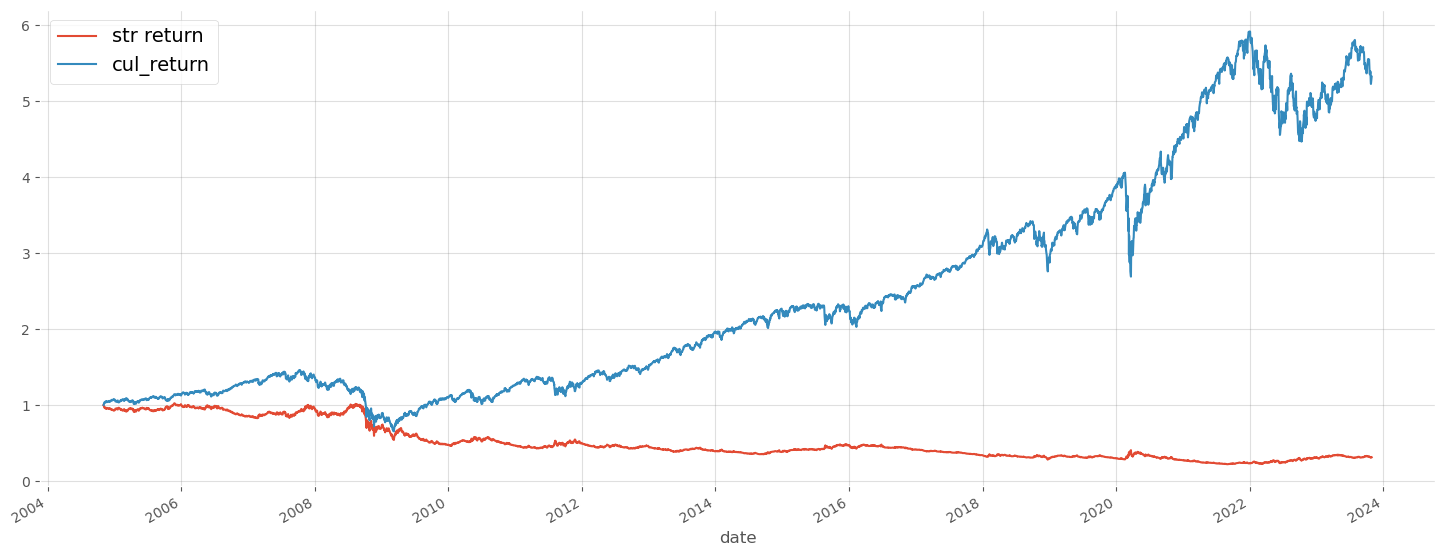

In [32]:
# RSI_MACD(12,30,5,14)

# Part2 
## Sharpe ratio

In [87]:
def sharpe_ratio(FAANG2):
    daily_returns = FAANG2["str return"].pct_change()
    Sharpe =np.sqrt(253) * (daily_returns.mean() / daily_returns.std())
    return Sharpe

## Maximum Drawdown & Duration, MDD 

In [95]:
def mdd_dur(FAANG2):
    FAANG2["max_gross_performance"] = FAANG2["str return"].cummax()
    FAANG2['drawdown'] = (FAANG2["max_gross_performance"] - FAANG2["str return"])/FAANG2["max_gross_performance"]
    FAANG2['drawdown'].max()
    stock_drawdown = pd.concat([FAANG2[FAANG2.drawdown==0],FAANG2[-1:]],axis=0)
    lst_day = []
    lst_drawdown = []
    for i in range(len(stock_drawdown) - 1):
        days = (stock_drawdown.index[i+1] - stock_drawdown.index[i]).days
        max_drawdown = FAANG2[stock_drawdown.index[i]:stock_drawdown.index[i+1]]["drawdown"].max()
        lst_day.append(days)
        lst_drawdown.append(max_drawdown)

    drawdown = pd.DataFrame([lst_day,lst_drawdown]).T
    drawdown.columns = ["days", "drawdown"]    
    mdd = drawdown.loc[drawdown["drawdown"].nlargest(1).index]
    return float(str(mdd["days"]).split()[1]),float(str(mdd["drawdown"]).split()[1])

## Compound annual growth rate, CAGR

In [35]:
def CAGR(FAANG2):
    days_I =(FAANG2.index[-1] - FAANG2.index[0]).days
    FAANG2 = FAANG2.dropna()
    CAGR_I =(((FAANG2["str return"][-1]+1) / (FAANG2["str return"][0]+1))**(365.0/days_I))- 1
    return CAGR_I 

## How much is left on your account

In [36]:
def money_left(stock,capital):
    return (stock["str return"][-1]/stock["str return"][1])*capital

In [98]:
spy0=spy.copy()
spy0["str return"] = spy0["log_return"].cumsum().apply(np.exp)

## DataFrame

In [99]:
capital = 1e5

sharpe0 = sharpe_ratio(spy0)
dur0,mdd0    = mdd_dur(spy0)
CAGR0   = CAGR(spy0)
left0   = money_left(spy0,capital)

sharpe1 = sharpe_ratio(df_threshold)
dur1,mdd1    = mdd_dur(df_threshold)
CAGR1   = CAGR(df_threshold)
left1   = money_left(df_threshold,capital)

sharpe2 = sharpe_ratio(df_rsi)
dur2,mdd2    = mdd_dur(df_rsi)
CAGR2   = CAGR(df_rsi)
left2   = money_left(df_rsi,capital)

sharpe3 = sharpe_ratio(df_bb)
dur3,mdd3    = mdd_dur(df_bb)
CAGR3   = CAGR(df_bb)
left3   = money_left(df_bb,capital)

sharpe4 = sharpe_ratio(df_cm)
dur4,mdd4    = mdd_dur(df_cm)
CAGR4   = CAGR(df_cm)
left4   = money_left(df_cm,capital)

sharpe5 = sharpe_ratio(df_macd)
dur5,mdd5    = mdd_dur(df_macd)
CAGR5   = CAGR(df_macd)
left5   = money_left(df_macd,capital)

In [104]:
names=["Sharpe ratio","MDD","Duration","CAGR","money left"]
spy_data = [sharpe0,mdd0,dur0,CAGR0,left0]
threshold = [sharpe1,mdd1,dur1,CAGR1,left1]
rsi = [sharpe2,mdd2,dur2,CAGR2,left2]
bb = [sharpe3,mdd3,dur3,CAGR3,left3]
cm = [sharpe4,mdd4,dur4,CAGR4,left4]
macd = [sharpe5,mdd5,dur5,CAGR5,left5]
data = {' ': names,
        "SPY":spy_data,
        'Threshold':threshold,
        'RSI':rsi,
        'Bollinger Bands': bb,
        'Combine-mean-reversion': cm,
        'MACD':macd}
data = pd.DataFrame(data)
data = data.set_index(' ')
pd.options.display.float_format = '{:.6f}'.format
data

,SPY,Threshold,RSI,Bollinger Bands,Combine-mean-reversion,MACD
,,,,,,
Sharpe ratio,0.554084,3.019754,3.758722,2.556283,4.034131,2.501744
MDD,0.551894,0.065835,0.176846,0.145197,0.156522,0.149733
Duration,1773.000000,25.000000,72.000000,17.000000,22.000000,61.000000
CAGR,0.062385,0.258804,0.910792,0.438778,1.002246,0.524841
money left,531752.281330,971331.640864,45372257543.165588,201369907.127472,109712512663.678879,592209714.051807
